# Diffusivity-Related Analysis 

# Importations

In [2]:
import numpy as np
from scipy.io import loadmat, savemat
from scipy.optimize import curve_fit
from tqdm import tqdm

In [3]:
from StochasticForceInference.StochasticForceInference import *
from StochasticForceInference.fun_SFI import Compute_diffusion

In [4]:
import ComputeObservables as co

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
from mpltools import annotation

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.4)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=200)
rc('savefig', dpi=200)

# Global variables

In [6]:
kT = 4e-21

# Find Experiment with the Smallest Offset on Diffusivities

In [7]:
### PS in salted water (3-um or 6-um spheres) 
dir0_0 = '../../analysis_droplets/traj_and_results/ref_PS_water/maxou_PRR_SFI_order_2/data_exp_PS_exp_2020_analysis_20230930_filename_data_exp_glass_exp_2020_analysis_20230322_filename_TRAJ_MAXOU_fit_result_dur_27052020_n_r_fix_0p0513_wav_532_r_1p516_n_1p597.mat'
dir0_1 = '../../analysis_droplets/traj_and_results/ref_PS_water/C4_SFI_order_2/data_exp_PS_exp_20211019_analysis_20230929_filename_data_exp_glass_exp_20211019_analysis_20230419_filename_TRAJ_C4_fit_result_rigid_08122021rp_1p5185_np_1p5819.mat'
dir0_2 = '../../analysis_glass/verre_2023_03_3um/5/data_exp_glass_exp_20230310_analysis_20230422_filename_traj_rp_1p4749_np_1p5843.mat'
dir0_3 = '../../analysis_glass/verre_2023_08_6um/5/data_exp_PS_exp_20230824_analysis_20230829_filename_traj_rp_2p9713_np_1p5884_vid_5.mat'
dir0_4 = '../../analysis_glass/verre_2023_08_6um/3/data_exp_PS_exp_20230824_analysis_20230829_filename_traj_rp_2p9864_np_1p5864_vid_3.mat'
dir0_5 = '../../analysis_glass/verre_2023_08_6um/1/data_exp_PS_exp_20230824_analysis_20230829_filename_traj_rp_2p9765_np_1p5862_vid_1.mat'
dir0_6 = '../../analysis_droplets/traj_and_results/ref_PS_water/PS_3um_march_2023/3/data_exp_glass_exp_20230310_analysis_20230424_filename_traj_rp_1p4749_np_1p5812.mat'
dir0_7 = '../../analysis_droplets/traj_and_results/ref_PS_water/PS_3um_march_2023/6/data_exp_glass_exp_20230310_analysis_20230424_filename_traj_rp_1p4711_np_1p5834.mat'
dir0_8 = '../../analysis_droplets/traj_and_results/ref_PS_water/PS_3um_march_2023/5/data_exp_glass_exp_20230310_analysis_20230422_filename_traj_rp_1p4749_np_1p5843.mat'
dir0_9 = './PS_3um_water_20240909_fps100/data_exp_PS_exp_20240909_analysis_20250707_filename_traj_rp_1p4768_np_1p582_vid_1.mat'

In [8]:
data0_0 = loadmat(dir0_0, squeeze_me=True)
data0_1 = loadmat(dir0_1, squeeze_me=True)
data0_2 = loadmat(dir0_2, squeeze_me=True)
data0_3 = loadmat(dir0_3, squeeze_me=True)
data0_4 = loadmat(dir0_4, squeeze_me=True)
data0_5 = loadmat(dir0_5, squeeze_me=True)
data0_6 = loadmat(dir0_6, squeeze_me=True)
data0_7 = loadmat(dir0_7, squeeze_me=True)
data0_8 = loadmat(dir0_8, squeeze_me=True)
data0_9 = loadmat(dir0_9, squeeze_me=True)

In [9]:
datas_0 = [data0_0, data0_1, data0_2, data0_3, data0_4, data0_5, data0_6, data0_7, data0_8, data0_9]

In [10]:
for i, data in enumerate(datas_0[:]):
    print(i, data['fitted_b'] * 1e9)

0 78.50698687091214
1 143.10763334737453
2 39.2879748851993
3 3.400390025093924
4 93.16159987839524
5 31.561167891730033
6 40.80862527824976
7 81.45964423271222
8 39.2879748851993
9 1.6346255087281993


In [11]:
### AR-1000 droplets in pure water
dir1 = '../../analysis_droplets/results/2nd_try_only_perfect_exp/AR1000_water/data_after_analysis/'
dir1_0 = dir1 + 'data_exp_AR1000_exp_20230627_analysis_20240108_filename_traj_rp_1p6166_np_1p4649_vid_3.mat'
dir1_1 = dir1 + 'data_exp_AR1000_exp_20230721_analysis_20240108_filename_traj_rp_1p5248_np_1p4669_vid_10.mat'
dir1_2 = dir1 + 'data_exp_AR1000_exp_20230912_analysis_20240108_filename_traj_rp_2p004_np_1p4597_vid_3.mat'
dir1_3 = dir1 + 'data_exp_AR1000_exp_20230912_analysis_20240108_filename_traj_rp_2p0075_np_1p4584_vid_1.mat'

In [12]:
data1_0 = loadmat(dir1_0, squeeze_me=True)
data1_1 = loadmat(dir1_1, squeeze_me=True)
data1_2 = loadmat(dir1_2, squeeze_me=True)
data1_3 = loadmat(dir1_3, squeeze_me=True)

In [13]:
datas_1 = [data1_0, data1_1, data1_2, data1_3]

# Brenner vs. Padé

In [14]:
def Dz_z(z, r=1.5e-6):
    return (6 * z ** 2 + 2 * r * z) / (6 * z ** 2 + 9 * r * z + 2 * r ** 2)

In [15]:
from mpmath import nsum
from math import acosh, sinh, inf

def sum_brenner(z, a=1.5e-6):
    alpha = acosh((a+z) / a)
    def f(n):
        p = (n * (n + 1) / ((2 * n - 1) * (2 * n + 3))) 
        num = (2 * sinh((2 * n + 1) * alpha) + (2 * n + 1) * sinh(2 * alpha))
        denom = 4 * sinh((n + 1 / 2) * alpha) ** 2 - (2 * n + 1) ** 2 * sinh(alpha) ** 2
        return p * (num / denom - 1)
    res = nsum(f, [1, inf])
    res = 4/3 * sinh(alpha) * res
    res = 1 / res
    return res

In [16]:
a = 1.5e-6

zz = np.linspace(30e-9, 3e-6, 100)

In [17]:
pade = Dz_z(zz, r=a)
lubr = zz / a

In [18]:
bren = np.zeros_like(zz)
for i in tqdm(range(len(zz))):
    bren[i] = sum_brenner(zz[i], a=a)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 140.57it/s]


In [19]:
relative_error_lubr = np.abs((bren - lubr) / bren)
relative_error_pade = np.abs((bren - pade) / bren)

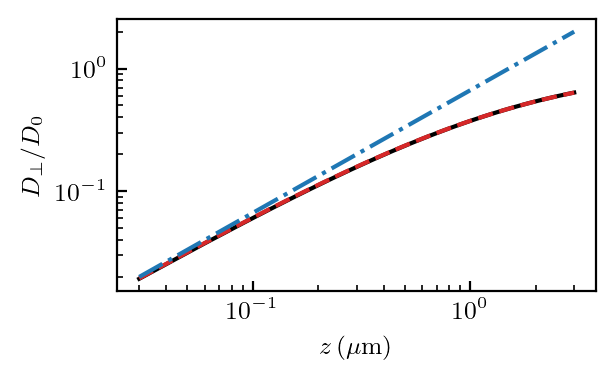

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8/2.54, 5/2.54))

ax.plot(zz*1e6, bren, ls='-', c='k')
ax.plot(zz*1e6, pade, ls='--', c='tab:red')
ax.plot(zz*1e6, lubr, ls='-.', c='tab:blue')

ax.set(xscale='log', yscale='log', xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'$D_\perp / D_0$')

plt.tight_layout()
plt.show()

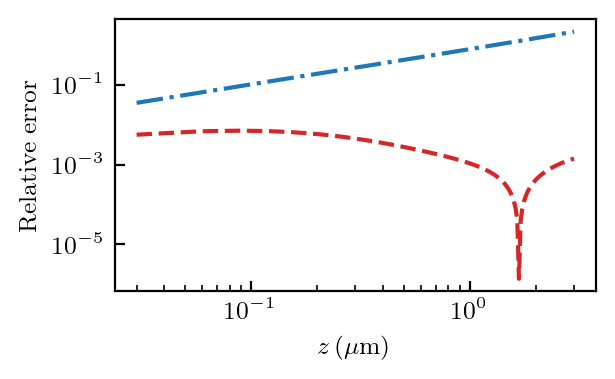

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8/2.54, 5/2.54))

ax.plot(zz*1e6, relative_error_lubr, ls='-.', c='tab:blue')
ax.plot(zz*1e6, relative_error_pade, ls='--', c='tab:red')

ax.set(xscale='log', yscale='log', xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'Relative error')

plt.tight_layout()
plt.show()

In [22]:
diffusivities = {
    'zz': np.copy(zz), 
    'pade': np.copy(pade), 
    'brenner': np.copy(bren), 
    'lubrication': np.copy(lubr), 
    'relative_error_pade': np.copy(relative_error_pade), 
    'relative_error_lubr': np.copy(relative_error_lubr), 
}

# Naive Diffusivity Computation

In [23]:
data = datas_0[-1]

In [24]:
z = data['z_dedrift']
fps = data['fps']
a = data['r']
D0 = data['D0']

In [25]:
def naive(bins_edges, traj_z, times=[1]):
    # We first get all the different variables of the problem
    Y = bins_edges
    zz = traj_z
    # We choose over wich time we want to compute the diffusion coefficient     
    # We initialize the variable used to store the results.
    res = np.zeros((len(times), len(Y[:-1])))
    err = np.zeros((len(times), len(Y[:-1])))
    for n, i in enumerate(times):
        # Compute the Delta x = x(Dt + t) - x(t) for given Dt -- same over y
        Dzs = zz[i:] - zz[0:-i]
        Dzs = (Dzs ** 2) / (2 * i/fps)
        # Now for each z-bin we are going to measure the z position
        for m in range(len(Y)-1):
            # We take the Dz corresponding the actual bin 
            dz = Dzs[(zz[:-i] > Y[m]) & (zz[:-i] < Y[m+1])]
            res[n,m] = np.nanmean(dz) 
            err[n,m] = np.nanstd(dz) / np.sqrt(len(dz))
    res = np.nanmean(res, axis=0)
    err = np.nanmean(err, axis=0)
    return res, err

In [26]:
bins_edges = np.logspace(np.log10(30e-9), np.log10(2e-6), 30)

In [27]:
exp_naive, err_naive = naive(bins_edges, z)
bins = bins_edges[:-1]

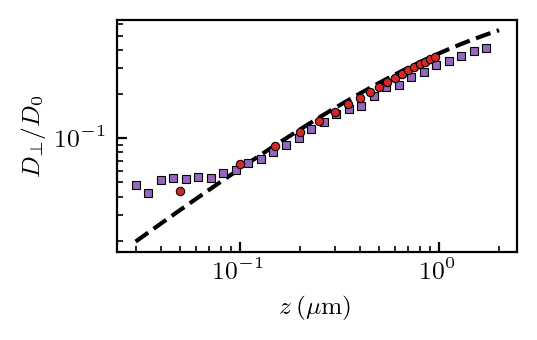

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7/2.54, 4.5/2.54))

ax.plot(bins_edges*1e6, Dz_z(bins_edges, r=a), ls='--', c='k')
ax.plot(bins*1e6, exp_naive / D0, ls='', marker='s', ms=3, c='tab:purple')
ax.plot(data['x_D_perp_z']*1e6, data['y_D_perp_z'], ls='', marker='o', ms=3, c='tab:red')

ax.set(xscale='log', yscale='log', xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'$D_\perp / D_0$')

plt.tight_layout()
plt.show()

In [29]:
diffusivities['bins'] = np.copy(bins)
diffusivities['D_exp_naive'] = np.copy(exp_naive)
diffusivities['D_err_naive'] = np.copy(err_naive)
diffusivities['D0'] = D0

In [30]:
# savemat('diffusivities.mat', diffusivities)

# Auto-Correlations

In [31]:
data = datas_0[0]

In [35]:
def autocor(x):
    autocor_dx = x[1:] - x[:-1]
    autocor_dx = autocor_dx - np.mean(autocor_dx)
    sigma2_x = np.mean(autocor_dx[1:] * autocor_dx[:-1]) * (1 - 2 * 109/750)
    err_x = np.sqrt(sigma2_x)
    return err_x

In [36]:
autocor(data['x']) * 1e9

9.827933891411012

In [37]:
autocor(data['z']) * 1e9

4.7308666687694725